# **Visualization**

In [39]:
!pip install geemap folium google-cloud-storage rasterio matplotlib localtileserver ipyleaflet  osmnx > /dev/null 2>&1

###  **1. Loading Library and Data**

In [2]:
import ee
import geemap
import os
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import rasterio
import folium
from folium.plugins import TimeSliderChoropleth
from branca.colormap import LinearColormap

drive.mount('/content/drive')
work_dir = '/content/drive/MyDrive/UHI-Detection-Analysis/data/raw/'
os.makedirs(work_dir, exist_ok=True)


Mounted at /content/drive


In [3]:
ee.Authenticate()
ee.Initialize(project='manifest-pride-258211')

In [32]:
lst_2015 = os.path.join(work_dir, 'LST_2015_Hamburg_test.tif')
lst_2025 = os.path.join(work_dir, 'LST_2025_Hamburg_test.tif')

### **1. LST Heatmap (Matplotlib) - Basic Visualization**

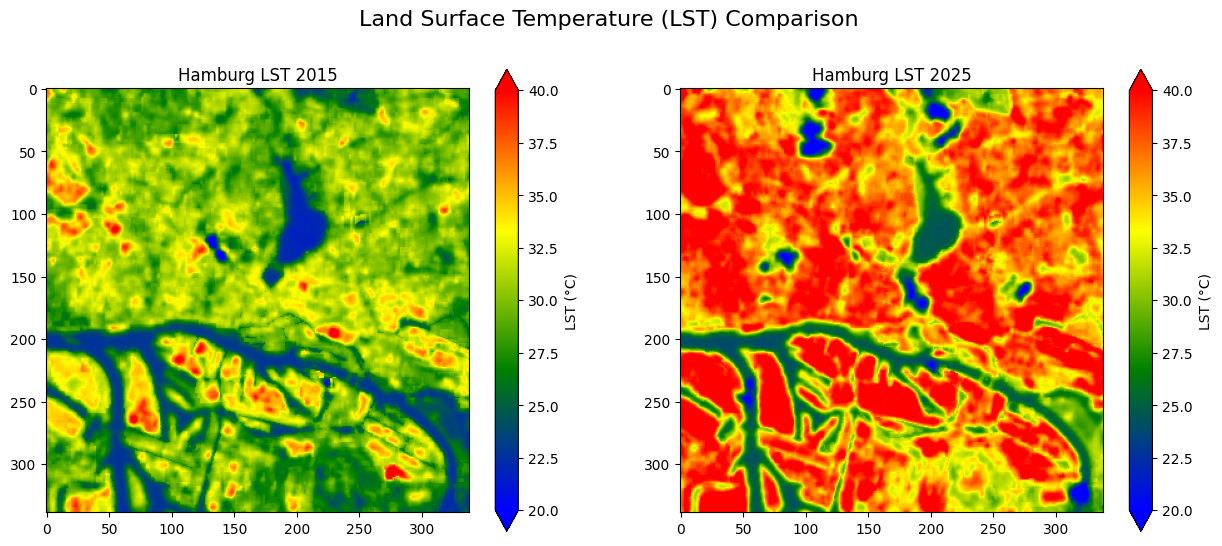

In [33]:
from matplotlib.colors import LinearSegmentedColormap

def load_lst(tif_path):
    with rasterio.open(tif_path) as src:
        lst = src.read(1)
        lst[lst == src.nodata] = np.nan  # NaN değerleri filtrele
    return lst

lst_2015 = load_lst(lst_2015)
lst_2025 = load_lst(lst_2025)

colors = ["blue", "green", "yellow", "red"]
cmap = LinearSegmentedColormap.from_list("lst_cmap", colors)


plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(lst_2015, cmap=cmap, vmin=20, vmax=40)
plt.colorbar(label='LST (°C)', extend='both')
plt.title('Hamburg LST 2015')

plt.subplot(1, 2, 2)
plt.imshow(lst_2025, cmap=cmap, vmin=20, vmax=40)
plt.colorbar(label='LST (°C)', extend='both')
plt.title('Hamburg LST 2025')

plt.suptitle('Land Surface Temperature (LST) Comparison', fontsize=16)

save_dir = '/content/drive/MyDrive/GitHub_Repos/urban-heat-island/figures/'
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'lst_comparison.png')

plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

### **2. Interactive Map Time Slider**

#### **2.1 Folium Map Slider with GeoJson**

In [51]:
import os
import rasterio
import numpy as np
import folium
import matplotlib.pyplot as plt
from rasterio.warp import transform_bounds
from IPython.display import display

def tiff_to_rgb(path):
    with rasterio.open(path) as src:
        arr = src.read(1).astype(float)
        bounds = src.bounds
        src_crs = src.crs

        # Koordinatları WGS84'e dönüştür
        wgs_bounds = transform_bounds(src_crs, 'EPSG:4326', *bounds)

        # Normalize ve renk haritası
        arr = np.ma.masked_equal(arr, src.nodata)
        arr_min, arr_max = np.nanmin(arr), np.nanmax(arr)
        arr_norm = (arr - arr_min) / (arr_max - arr_min)
        arr_norm = np.clip(arr_norm, 0, 1)

        cmap = plt.get_cmap('jet')
        rgba_img = cmap(arr_norm)
        rgb = (rgba_img[:, :, :3] * 255).astype(np.uint8)

        return rgb, wgs_bounds

# TIFF dosyalarının yolları
tiff_2015 = os.path.join(work_dir, 'LST_2015_Hamburg.tif')
tiff_2025 = os.path.join(work_dir, 'LST_2025_Hamburg.tif')

# Görselleri yükle
rgb_2015, bounds_2015 = tiff_to_rgb(tiff_2015)
rgb_2025, bounds_2025 = tiff_to_rgb(tiff_2025)

# Harita merkezi
center_lat = (bounds_2015[1] + bounds_2015[3]) / 2
center_lon = (bounds_2015[0] + bounds_2015[2]) / 2

m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Katmanları ekle
folium.raster_layers.ImageOverlay(
    image=rgb_2015,
    bounds=[[bounds_2015[1], bounds_2015[0]], [bounds_2015[3], bounds_2015[2]]],
    opacity=0.8,
    name='LST 2015',
).add_to(m)

folium.raster_layers.ImageOverlay(
    image=rgb_2025,
    bounds=[[bounds_2025[1], bounds_2025[0]], [bounds_2025[3], bounds_2025[2]]],
    opacity=0.8,
    name='LST 2025',
).add_to(m)

# Katman kontrolü ve harita gösterimi
folium.LayerControl().add_to(m)
output_dir = '/content/drive/MyDrive/outputs'
os.makedirs(output_dir, exist_ok=True)


#m.save('/content/drive/MyDrive/GitHub_Repos/urban-heat-island/maps/lst_timeslider_10.html')
#display(m)

#### **2.2 Mapbox HTML Map**

In [72]:
import folium
from folium.plugins import TimeSliderChoropleth
import branca.colormap as cm
import pandas as pd

# Örnek: 2015-2025 arası tüm LST dosyalarını listeleyin
lst_files = {
    '2015': '/content/drive/MyDrive/UHI-Detection-Analysis/data/raw/LST_2015_Hamburg.tif',
    #'2016': '/content/drive/.../LST_2016_Hamburg.tif',
    # ... Diğer yıllar
    '2025': '/content/drive/MyDrive/UHI-Detection-Analysis/data/raw/LST_2025_Hamburg.tif'
}

# LST verilerini bir DataFrame'de topla
dates = []
rasters = []

for year, path in lst_files.items():
    with rasterio.open(path) as src:
        bounds = src.bounds
        lst = src.read(1)
        lst[lst == src.nodata] = np.nan
    dates.append(year)
    rasters.append(lst)


import plotly.express as px
import pandas as pd

hamburg_bounds = [
    [[9.8, 53.4], [10.2, 53.4], [10.2, 53.7], [9.8, 53.7], [9.8, 53.4]]
]

# Örnek bir DataFrame oluştur (gerçek veri ile değiştirin)
df = pd.DataFrame({
    'Year': dates,
    'LST': [np.nanmean(lst) for lst in rasters],
    'Geometry': [hamburg_bounds] * len(dates)  # GeoJSON geometrisi
})

fig = px.choropleth_mapbox(
    df,
    geojson=df['Geometry'],
    locations=df.index,
    color='LST',
    animation_frame='Year',
    mapbox_style="carto-positron",
    zoom=10,
    center={"lat": 53.55, "lon": 9.99},
    opacity=0.5,
    color_continuous_scale="Inferno"
)
fig.write_html('/content/drive/MyDrive/GitHub_Repos/urban-heat-island/maps/mapbox_time_slider.html')

In [ ]:
!pip install nbstripout > /dev/null 2>&1

In [ ]:
nbstripout /content/drive/MyDrive/GitHub_Repos/urban-heat-island/notebooks/07_visualization_deploy.ipynb
